In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [122]:
df_abbrev = pd.read_csv('data_and_models/data/WA-clean-abbrev.csv')

In [125]:
df_abbrev.columns

Index(['Unnamed: 0', 'id', 'state', 'stop_date', 'stop_time', 'location_raw',
       'county_name', 'county_fips', 'fine_grained_location',
       'police_department', 'driver_gender', 'driver_age_raw', 'driver_age',
       'driver_race_raw', 'driver_race', 'violation_raw', 'violation',
       'search_conducted', 'search_type_raw', 'search_type',
       'contraband_found', 'stop_outcome', 'is_arrested', 'violations',
       'officer_id', 'officer_gender', 'officer_race', 'highway_type',
       'road_number', 'milepost', 'lat', 'lon', 'contact_type', 'enforcements',
       'drugs_related_stop'],
      dtype='object')

In [5]:
df = df_abbrev.drop(columns=['state', 'stop_time', 'location_raw', 'county_fips', 'police_department', 'driver_age_raw', 'driver_race_raw',
                         'violation_raw','search_type_raw', 'is_arrested'])

In [6]:
df.head()

,id,stop_date,county_name,fine_grained_location,driver_gender,driver_age,driver_race,violation,search_conducted,search_type,...,officer_gender,officer_race,highway_type,road_number,milepost,lat,lon,contact_type,enforcements,drugs_related_stop
0,WA-2009-0000001,2009-01-01,Spokane County,S-002-280,M,27.0,White,Equipment,False,NaN,...,M,White,S,002,280.0,47.643152,-117.544585,Self-Initiated Contact,3,False
1,WA-2009-0000002,2009-01-01,NaN,C-018-NA,M,21.0,White,Speeding,False,NaN,...,F,White,C,018,NaN,NaN,NaN,Self-Initiated Contact,3,False
2,WA-2009-0000003,2009-01-01,King County,S-516-7,F,17.0,White,Speeding,False,NaN,...,M,White,S,516,7.0,47.373378,-122.209356,Self-Initiated Contact,3,False
3,WA-2009-0000004,2009-01-01,King County,S-515-2,M,31.0,Asian,"License,Lights,Paperwork",True,Incident to Arrest,...,M,White,S,515,2.0,47.414073,-122.197144,Self-Initiated Contact,"1,1,1",False
4,WA-2009-0000005,2009-01-01,Kitsap County,S-303-8,F,24.0,White,Safe movement,False,NaN,...,M,White,S,303,8.0,47.659471,-122.675907,Self-Initiated Contact,"3,3",False


In [7]:
df['stop_date'] = pd.to_datetime(df.stop_date)

In [ ]:
#df.set_index(df['stop_date'], inplace= True)

In [8]:
df.driver_age.fillna(df.driver_age.mean(), inplace=True)

In [9]:
df = df.dropna(subset=['driver_race', 'driver_gender'])

In [10]:
df.isnull().sum() #no missing values for search_conducted - could be interesting to look for

id                           0
stop_date                    0
county_name              10427
fine_grained_location        0
driver_gender                0
driver_age                   0
driver_race                  0
violation                  949
search_conducted             0
search_type              67276
contraband_found             0
stop_outcome               998
violations                 949
officer_id                   0
officer_gender               0
officer_race                 0
highway_type                 0
road_number                  0
milepost                  7648
lat                      10427
lon                      10427
contact_type               550
enforcements               998
drugs_related_stop           0
dtype: int64

In [11]:
df['driver_gender'] = pd.Series(np.where(df.driver_gender.values == 'F', 1, 0),
          df.index)

In [12]:
df['officer_gender'] = pd.Series(np.where(df.officer_gender.values == 'F', 1, 0),
          df.index)

In [126]:
race_dummies = pd.get_dummies(df.driver_race)

In [127]:
race_dummies.head()

,Asian,Black,Hispanic,Other,White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1


In [135]:
officer_race = pd.get_dummies(df.officer_race)
officer_race.columns = ['O_Asian', 'O_Black', 'O_Hispanic', 'O_Other', 'O_White']
officer_race.head()

,O_Asian,O_Black,O_Hispanic,O_Other,O_White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [136]:
df[df['search_conducted'] == False]

,id,stop_date,county_name,fine_grained_location,driver_gender,driver_age,driver_race,violation,search_conducted,search_type,...,officer_gender,officer_race,highway_type,road_number,milepost,lat,lon,contact_type,enforcements,drugs_related_stop
0,WA-2009-0000001,2009-01-01,Spokane County,S-002-280,0,27.000000,White,Equipment,False,NaN,...,0,White,S,002,280.0,47.643152,-117.544585,Self-Initiated Contact,3,False
1,WA-2009-0000002,2009-01-01,NaN,C-018-NA,0,21.000000,White,Speeding,False,NaN,...,1,White,C,018,NaN,NaN,NaN,Self-Initiated Contact,3,False
2,WA-2009-0000003,2009-01-01,King County,S-516-7,1,17.000000,White,Speeding,False,NaN,...,0,White,S,516,7.0,47.373378,-122.209356,Self-Initiated Contact,3,False
4,WA-2009-0000005,2009-01-01,Kitsap County,S-303-8,1,24.000000,White,Safe movement,False,NaN,...,0,White,S,303,8.0,47.659471,-122.675907,Self-Initiated Contact,"3,3",False
5,WA-2009-0000006,2009-01-01,Pierce County,I-005-138,0,36.000000,White,"DUI,License,Speeding",False,NaN,...,0,White,I,005,138.0,47.240716,-122.356301,Self-Initiated Contact,"1,1,1",False
6,WA-2009-0000007,2009-01-01,Benton County,S-395-16,0,26.000000,White,Speeding,False,NaN,...,0,White,S,395,16.0,46.196569,-119.160668,Self-Initiated Contact,3,False
7,WA-2009-0000008,2009-01-01,Thurston County,I-005-110,0,61.000000,White,Safe movement,False,NaN,...,0,White,I,005,110.0,47.048975,-122.818612,Self-Initiated Contact,"3,3",False
8,WA-2009-0000009,2009-01-01,NaN,C-017-991,0,33.000000,Black,"License,Safe movement",False,NaN,...,0,White,C,017,991.0,NaN,NaN,Self-Initiated Contact,"1,3,3",False
9,WA-2009-0000010,2009-01-01,Kitsap County,S-303-1,1,18.000000,White,"Paperwork,Safe movement,Speeding",False,NaN,...,0,White,S,303,1.0,47.610495,-122.628756,Self-Initiated Contact,"3,3,3",False
10,WA-2009-0000011,2009-01-01,Pierce County,S-016-8,0,19.000000,White,Safe movement,False,NaN,...,0,White,S,016,8.0,47.282902,-122.560638,Self-Initiated Contact,3,False


In [137]:
merged = df.merge(race_dummies, left_index=True, right_index=True)

In [138]:
merged = merged.merge(officer_race, left_index=True, right_index=True)

In [139]:
merged.set_index(merged['stop_date'], inplace=True)

In [140]:
merged.head()

,id,stop_date,county_name,fine_grained_location,driver_gender,driver_age,driver_race,violation,search_conducted,search_type,...,Asian,Black,Hispanic,Other,White,O_Asian,O_Black,O_Hispanic,O_Other,O_White
stop_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,WA-2009-0000001,2009-01-01,Spokane County,S-002-280,0,27.0,White,Equipment,False,NaN,...,0,0,0,0,1,0,0,0,0,1
2009-01-01,WA-2009-0000002,2009-01-01,NaN,C-018-NA,0,21.0,White,Speeding,False,NaN,...,0,0,0,0,1,0,0,0,0,1
2009-01-01,WA-2009-0000003,2009-01-01,King County,S-516-7,1,17.0,White,Speeding,False,NaN,...,0,0,0,0,1,0,0,0,0,1
2009-01-01,WA-2009-0000004,2009-01-01,King County,S-515-2,0,31.0,Asian,"License,Lights,Paperwork",True,Incident to Arrest,...,1,0,0,0,0,0,0,0,0,1
2009-01-01,WA-2009-0000005,2009-01-01,Kitsap County,S-303-8,1,24.0,White,Safe movement,False,NaN,...,0,0,0,0,1,0,0,0,0,1


In [141]:
merged['drugs_related_stop'] = pd.Series(np.where(merged.drugs_related_stop.values == False, 0, 1),
          merged.index)


In [142]:
merged['search_conducted'] = pd.Series(np.where(merged.search_conducted.values == False, 0, 1),
          merged.index)

In [143]:
merged.columns

Index(['id', 'stop_date', 'county_name', 'fine_grained_location',
       'driver_gender', 'driver_age', 'driver_race', 'violation',
       'search_conducted', 'search_type', 'contraband_found', 'stop_outcome',
       'violations', 'officer_id', 'officer_gender', 'officer_race',
       'highway_type', 'road_number', 'milepost', 'lat', 'lon', 'contact_type',
       'enforcements', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'O_Asian', 'O_Black', 'O_Hispanic', 'O_Other',
       'O_White'],
      dtype='object')

In [145]:
X = merged.loc[:, ['driver_gender', 'driver_age', 'officer_gender', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'O_Asian', 'O_Black', 'O_Hispanic', 'O_Other',
       'O_White']]

In [146]:
X = X.drop(columns = ['Other', 'O_Other'])

In [147]:
X.head()

,driver_gender,driver_age,officer_gender,drugs_related_stop,Asian,Black,Hispanic,White,O_Asian,O_Black,O_Hispanic,O_White
stop_date,,,,,,,,,,,,
2009-01-01,0,27.0,0,0,0,0,0,1,0,0,0,1
2009-01-01,0,21.0,1,0,0,0,0,1,0,0,0,1
2009-01-01,1,17.0,0,0,0,0,0,1,0,0,0,1
2009-01-01,0,31.0,0,0,1,0,0,0,0,0,0,1
2009-01-01,1,24.0,0,0,0,0,0,1,0,0,0,1


In [148]:
y = merged.loc[:, ['search_conducted']]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [150]:
logistic_model = LogisticRegression()

In [151]:
logistic_model.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
preds = logistic_model.predict_proba(X_test)

In [153]:
pos_preds = preds[:,1]

In [154]:
logistic_model.score(X_test, y_test)

0.9589668230373594

In [156]:
pos_preds

array([0.04047581, 0.06740375, 0.05476217, ..., 0.06212353, 0.05455807,
       0.02108193])

In [157]:
y_test.sum()

search_conducted    910
dtype: int64

In [158]:
log_loss(y_test, pos_preds)

0.16551623836957244

In [159]:
logistic_model.coef_

array([[-0.39548335, -0.02737902, -0.19371108,  5.28250498, -1.55052667,
        -0.78686568, -0.99368109, -1.47233947,  0.15452721, -0.1942213 ,
         0.27450823,  0.35084267]])

In [160]:
X.columns

Index(['driver_gender', 'driver_age', 'officer_gender', 'drugs_related_stop',
       'Asian', 'Black', 'Hispanic', 'White', 'O_Asian', 'O_Black',
       'O_Hispanic', 'O_White'],
      dtype='object')

In [161]:
#looking at some comparisons between race and getting searched

In [87]:
plot_df = merged.loc[:, ['driver_gender', 'driver_age', 'officer_gender', 'search_conducted', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White' ]]

In [112]:
plot_df_white = plot_df[plot_df.White == 1]
searches = plot_df_white.search_conducted.sum()/len(plot_df_white)
searches

0.043646671479127416

In [111]:
plot_df_black = plot_df[plot_df.Black ==1]
searches_black = plot_df_black.search_conducted.sum()/len(plot_df_black)
searches_black

0.08688881968234195

In [113]:
races =[ 'Asian', 'Black', 'Hispanic',
       'Other', 'White'] 
search_percents = []
for r in races:
    search = plot_df[plot_df[r] == 1]
    search_percents.append(search.search_conducted.sum()/len(search))

In [114]:
search_percents

[0.03859280651089525,
 0.08688881968234195,
 0.07350032959789057,
 0.1615819209039548,
 0.043646671479127416]

Text(0.5,1,'Probability of Getting Searched')

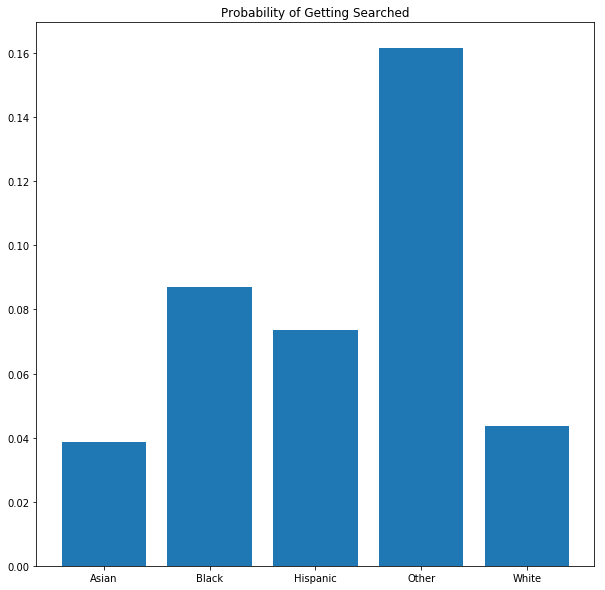

In [120]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(races,search_percents)
ax.set_title("Probability of Getting Searched")